# Standard Circuit Execution with the Restless Simulator

If we want, we can emulate qubit/qutrit reset with the `QutritRestlessSimulator` by modifying the
post-measurement transition matrix to implement reset. This allows us to execute qutrit circuits
with standard circuit execution. The post-measurement transition matrix is a matrix that is applied
to the quantum states after the measurement to account for effects like measurement back-action and
potentially reset. 

`QutritRestlessSimulator` simulates circuits using transition matrices, which capture measurement
probabilities as a Markov Chain. It also simulates post-measurement error as a transition matrix.
This matrix, for a single qutrit, contains the probabilities $\{p_{ij}\}$ to have state $|i\rangle$
as the output given state $|j\rangle$ as the input. The post-measurement transition matrix is given
as

$$
P_k = \begin{pmatrix}
p_{00}  &   p_{01}  &   p_{02}  \\
p_{10}  &   p_{11}  &   p_{12}  \\
p_{20}  &   p_{21}  &   p_{22}  \\
\end{pmatrix}.
$$

To implement reset, we set the post-measurement transition matrix such that the probability to have
the ground-state as the output $P_{0j}$ is always equal to one, i.e.,

$$ P_{reset}=\begin{pmatrix}
1&1&1\\
0&0&0\\
0&0&0\\
\end{pmatrix}.
$$

We pass this post-measurement transition matrix to the simulator in `run()` as the
`meas_transition_mats` parameter. Passing a single 3x3 NumPy array will use the same transition
matrix for each circuit. We can also pass a list of matrices, which tells the simulator to match
each circuit with a corresponding array in said list.


To demonstrate standard circuit execution with the simulator, we will use the same circuits from the
introductory tutorial and the tutorial on simulating qutrit circuits. We will then execute the leaky
circuits with restless and with standard circuit execution and compare them with the ideal circuit
results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate
from qiskit.quantum_info import Kraus

from restless_simulator.circuit import QutritQuantumChannelOperation, QutritUnitaryGate
from restless_simulator.simulator import QutritRestlessSimulator

In [2]:
# Create simulator
simulator = QutritRestlessSimulator()

## Create ideal and leaky circuits

Here we create ideal and leaky $R_X$ gates, i.e., instructions, to be used in circuits. They have
the same structure and construction as the ideal and leaky gates from the second tutorial titled
"Simulating Qutrit Circuits".

### Create leaky and ideal $R_X(\pi/2)$ gates

In [3]:
# Create leaky unitary

# Variable to control leakage
leakage_rotation = np.pi / 16
# Construct leaky gate as two rotations.
leaky_unitary = (
    # very small rotation from |1> to |2>
    np.array(
        [
            [1, 0, 0],
            [0, np.cos(leakage_rotation / 2), -1j * np.sin(leakage_rotation / 2)],
            [0, -1j * np.sin(leakage_rotation / 2), np.cos(leakage_rotation / 2)],
        ],
    )
    # X-pi/2 rotation between |0> and |1>
    @ np.array(
        [
            [np.cos(np.pi / 4), -1j * np.sin(np.pi / 4), 0],
            [-1j * np.sin(np.pi / 4), np.cos(np.pi / 4), 0],
            [0, 0, 1],
        ]
    )
)


In [4]:
leaky_gate = QutritUnitaryGate(leaky_unitary, label="U(pi/2)")
ideal_gate = RXGate(np.pi / 2)


### Create circuits


In [5]:
N_CIRCUITS = 10
leaky_circuits = []
ideal_circuits = []
for n in range(N_CIRCUITS):
    # Create leaky circuit
    nth_circ = QuantumCircuit(1)
    # Add leaky gate to qubit/qutrit 0.
    nth_circ.append(
        leaky_gate,
        [0],
    )
    # Add ideal qubit RX(pi/3) gates.
    for _ in range(n):
        nth_circ.rx(np.pi / 3, 0)
    leaky_circuits.append(nth_circ)

    # Create ideal circuit
    nth_ideal_circ = QuantumCircuit(1)
    nth_ideal_circ.append(
        ideal_gate,
        [0],
    )
    for _ in range(n):
        nth_ideal_circ.rx(np.pi / 3, 0)
    ideal_circuits.append(nth_ideal_circ)


In [6]:
ideal_circuits[4].draw()

┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q: ┤ Rx(π/2) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├
   └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘

In [7]:
leaky_circuits[4].draw()

┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q: ┤ U(pi/2) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├
   └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘

## Simulate with and without restless

Here we create our post-measurement transition matrix that implements qutrit reset.

In [15]:
# Create qutrit-reset transition matrix.
P_reset = np.array(
    [
        [1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
    ]
)


### Simulate all configurations

Now we simulate the leaky circuits with and without restless to show how qutrit reset impacts
measurement outcomes.

In [9]:
# Execute leaky circuits with restless circuit execution.
restless_leaky_job = simulator.run(leaky_circuits)

# Execute leaky circuits with standard circuit execution.
standard_leaky_job = simulator.run(leaky_circuits, meas_transition_mats=P_reset)


In [10]:
# Create expected probabilities array in the same way as with the previous tutorials.
expected_probs = (
    0.5 * np.cos(np.pi / 3 * np.arange(N_CIRCUITS, step=0.1) + np.pi / 2) + 0.5
)

If we plot the measurement probabilities with restless and standard circuit execution, we see that
standard circuit execution results in probabilities that are close to the expected ideal (i.e., the
cosine plot). This shows us that restless circuit execution is sensitive to leakage and that qutrit
reset mitigates the impact of leakage on measurement outcomes. Running a circuit with restless comes
with the cost of increased sensitivity and susceptibility to leakage into the $|2\rangle{}$ state.


In [11]:
from restless_simulator.utils import (
    extract_memory,
    restless_memory_to_memory,
    memory_to_probabilities,
)


Text(0, 0.5, 'Probability to Measure $|0\\rangle$')

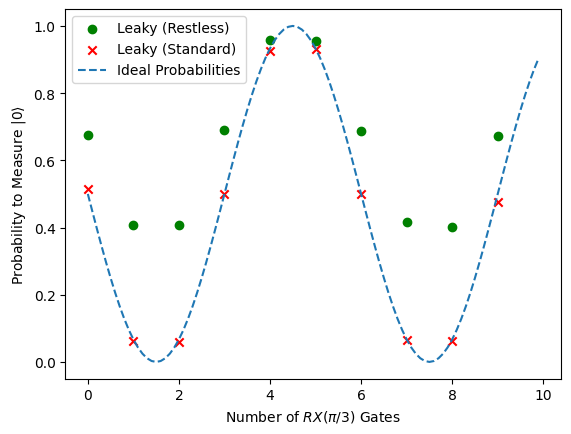

In [12]:
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(
        restless_memory_to_memory(extract_memory(restless_leaky_job))
    ),
    label="Leaky (Restless)",
    marker="o",
    color="g",
)
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(extract_memory(standard_leaky_job)),
    label="Leaky (Standard)",
    marker="x",
    color="r",
)
plt.plot(
    np.arange(N_CIRCUITS, step=0.1),
    expected_probs,
    linestyle="--",
    label="Ideal Probabilities",
)
plt.legend()
plt.xlabel("Number of $R_X(\\pi/3)$ Gates")
plt.ylabel("Probability to Measure $|0\\rangle$")


## Accumulated leakage during restless vs standard circuit execution

If we want to investigate the measurement states prior to measurement assignment, which can be used
to determine the accumulated leakage during an experiment, we can pass `return_meas_state=True` to
the simulator's `run()` method. The returned job object will then contain lists of measurement
labels which indicate the collapsed state prior to measurement assignment error. These are the
qutrit state labels '0', '1', and '2'. We can access these by calling `meas_state` on a result
instance, retrieved from `job.results()`. As we execute 10 circuits, there are 10 result instances;
each with a `meas_state` list.

Below we
1. execute circuits with and without qutrit reset and with `return_meas_state=True`,
2. collect the collapsed measurement state labels into a single array,
3. and compute the accumulated leakage for the measurement outcomes.

This allows us to compare the frequency of the $|2\rangle$ state in our measurements with standard
and restless circuit execution.


In [16]:
# Execute with qutrit reset
standard_job_meas_state = simulator.run(
    leaky_circuits, meas_transition_mats=P_reset, return_meas_state=True
)

# Execute with restless and without qutrit reset
restless_job_meas_state = simulator.run(leaky_circuits, return_meas_state=True)

In [21]:
# Collect collapsed measurement state labels
standard_measurement_states = np.array(
    [result.meas_state for result in standard_job_meas_state.result().results]
).astype(str)
restless_measurement_states = np.array(
    [result.meas_state for result in restless_job_meas_state.result().results]
).astype(str)

# Compute level of accumulatd |2>-state population
standard_leakage_accumulated = (
    np.sum(standard_measurement_states == "2") / standard_measurement_states.size
)
restless_leakage_accumulated = (
    np.sum(restless_measurement_states == "2") / restless_measurement_states.size
)
print(
    f"Average accumulated leakage levels were {standard_leakage_accumulated:0.4g} for standard "
    f"execution and {restless_leakage_accumulated:0.4g} for restless."
)


Average accumulated leakage levels were 0.004248 for standard execution and 0.3187 for restless.


As we see in the above leakage rates, standard circuit execution suppresses the rate at which we
would measure the $|2\rangle$ state. If our circuits were less leaky, these rates would be lower.
Though restless circuit execution is impacted by leakage, it does give us a large increase in
circuit execution speed. Before running a leaky or leakage-sensitive experiment with restless
circuit execution, you should make sure to analyse the trade-off between the speed gain and the
negative impact of leakage on the measurement outcomes.
